In [2]:
import numpy as np
nelems = 3  # Total number of elements
nnodes = 8  # Number of global nodes
vars_per_node = 6
nodes_per_elem = 4
dof_per_elem = vars_per_node * nodes_per_elem
global_dofs = nnodes*vars_per_node
blocks_per_elem = nodes_per_elem**2
nnz_per_block = vars_per_node**2

# Connectivity from local -> global
conn = [
    [0, 1, 2, 3], # Element 1 -> Global nodes 
    [2, 3, 4, 5], # Element 2 -> Global nodes
    [4, 5, 6, 7],
]

# Octo-garbonzo-mesh 
# nelems = 3  # Total number of elements
# nnodes = 8  # Number of global nodes
# dof_per_elem = 24
# vars_per_node = 6
# global_dofs = nnodes*vars_per_node

# # Connectivity from local -> global
# conn = np.random.randint(0, nnodes, size=(nelems, 4))

In [3]:
import numpy as np

# Create fake element stiffness matrix
def Kelem(ndof):
    return np.random.rand(ndof, ndof)


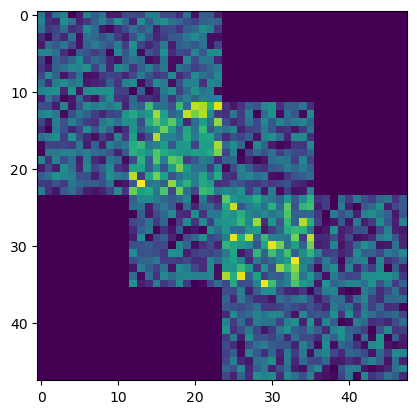

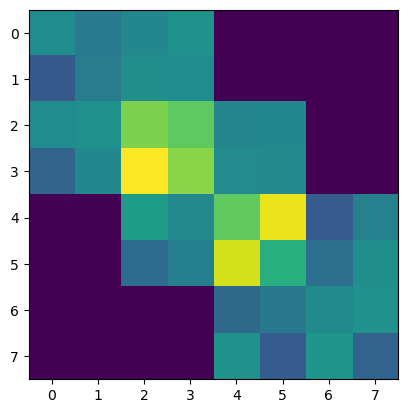

In [4]:
import matplotlib.pyplot as plt

# Assemble dense matrix
dense = np.zeros((global_dofs, global_dofs))
Kelem_list = [Kelem(dof_per_elem) for i in range(nelems)]

for i in range(nelems):
    Kelem_i = Kelem_list[i]
    local_node_conn = conn[i]

    local_dof_conn = [[vars_per_node*inode + idof for idof in range(6)] for inode in local_node_conn]
    local_dof_conn = np.array(local_dof_conn).flatten()

    global_ind = np.ix_(local_dof_conn, local_dof_conn)
    dense[global_ind] += Kelem_i


dense_nodal = np.zeros((nnodes, nnodes))
for i in range(nelems):
    Kelem_i = np.random.rand(nodes_per_elem, nodes_per_elem) + 1
    local_node_conn = np.array(conn[i])

    global_ind = np.ix_(local_node_conn, local_node_conn)
    dense_nodal[global_ind] += Kelem_i

plt.imshow(dense)
plt.show()
plt.imshow(dense_nodal)
plt.show()
    

rowPtr=[0, 4, 8, 14, 20, 26, 32, 36, 40]
colPtr=[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 7, 2, 3, 4, 5, 6, 7, 4, 5, 6, 7, 4, 5, 6, 7]
elem_indx_maps=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17], [10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29], [22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]]


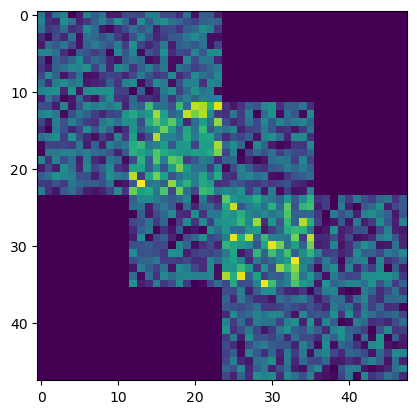

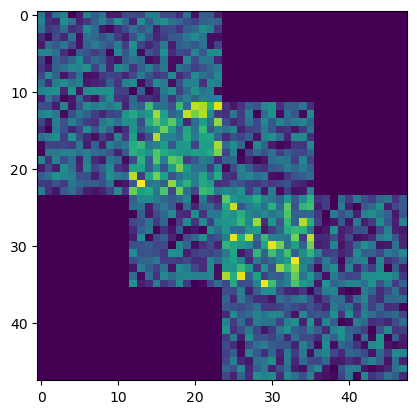

In [ ]:
from scipy.sparse import bsr_matrix
# Sparse matrix
blockDim = vars_per_node
mb = nnodes

# general version (maybe this would be done on CPU? just handling ints and map)
nnzb = 0
rowPtr = [0]
colPtr = []
for inode in range(nnodes): # each block row
    col_nodes = np.unique(np.array(
        [ind for elem_conn in conn if inode in elem_conn for ind in elem_conn ]
    ))
    row = inode
    # print(f"{row=} {col_nodes=}")

    nnzb_this_row = len(col_nodes)
    if nnzb_this_row > 0:
        nnzb += nnzb_this_row
        rowPtr += [nnzb]
        colPtr += list(col_nodes)

print(f"{rowPtr=}")
print(f"{colPtr=}")

elem_indx_maps = []
for ielem in range(nelems):
    this_elem_indx_map = []
    elem_conn = conn[ielem]
    for glob_block_row in elem_conn:
        col_istart = rowPtr[glob_block_row]
        col_iend = rowPtr[glob_block_row+1]
        # print(f"{glob_block_row=} {col_istart=} : {col_iend=}")

        for glob_block_col in elem_conn:

            # i is ind in colPtr that corresponds to this block
            # is also block start ind in values (ignoring strides)
            for i in range(col_istart, col_iend):
                if colPtr[i] == glob_block_col:
                    break
            this_elem_indx_map += [i]
    
    elem_indx_maps += [this_elem_indx_map]
            
print(f"{elem_indx_maps=}")

values = np.zeros(nnzb * nnz_per_block)

for e, elem_indx_map in enumerate(elem_indx_maps):
    Kelem_e = Kelem_list[e]

    for block in range(blocks_per_elem):
        val_start_indx = nnz_per_block * elem_indx_map[block]
        block_row = int(block / nodes_per_elem) 
        block_col = int(block % nodes_per_elem)
        current_block = Kelem_e[vars_per_node*block_row: (vars_per_node*(block_row+1)),
                                vars_per_node*block_col: (vars_per_node*(block_col+1))]
        values[val_start_indx:val_start_indx+nnz_per_block] += current_block.flatten()

values_scipy = values.reshape((nnzb, vars_per_node, vars_per_node))

bsr_mat =bsr_matrix((values_scipy,np.array(colPtr),np.array(rowPtr)), shape=(global_dofs, global_dofs))
dense_bsr = bsr_mat.toarray()
plt.imshow(dense_bsr)
plt.show()
plt.imshow(dense)
plt.show()

In [9]:
# Solve
from scipy.sparse.linalg import spilu
rhs = np.random.rand(nnodes*vars_per_node, 1)
soln = spilu(bsr_mat, drop_tol = 0.0, fill_factor= 10).solve(rhs)
# print(soln)
residual = dense_bsr @ soln - rhs
print(max(rhs))
print(max(residual))



[0.97238421]
[5.44009282e-15]


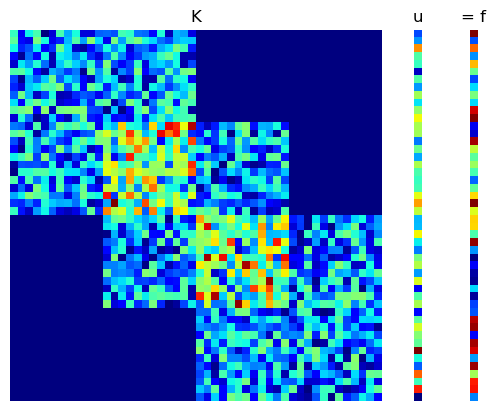

In [10]:
# Initialize a plot
fig, ax = plt.subplots(1, 3, figsize=(5, 4), constrained_layout = True, gridspec_kw={'width_ratios': [4, 0.5, 0.5]})
# Plot the matrix A
ax[0].imshow(dense_bsr, cmap="jet")
ax[0].set_title("K")
# ax[0].set_xlabel("Columns")
# ax[0].set_ylabel("Rows")
ax[1].imshow(soln, cmap="jet")
ax[1].set_title("u")
# ax[1].set_xlabel("1 column")
# ax[1].set_ylabel("Rows")
ax[2].imshow(rhs, cmap="jet")
ax[2].set_title("= f")
# ax[2].set_xlabel("1 column")
# ax[2].set_ylabel("=")
ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")
# plt.tight_layout()
plt.show() 